# Dash Application 2

In [65]:
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


df = pd.read_csv('cancer_ml_prediction.csv')
X = df.drop('class',axis=1)
feature_list = df.drop('class',axis=1).columns.tolist()
target = df['class']




In [105]:
eda_fig_1 = px.box(df, x='class',y='size')


In [103]:
eda_fig_2 = px.box(df, x='class',y='shape')

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.2, random_state=42)

### Models

In [75]:
pca = PCA(n_components=2)
pc_1, pc_2 = pca.fit_transform(X_train).T

In [77]:
rf = RandomForestClassifier().fit(X_train,y_train)
importances = pd.DataFrame({'feature':feature_list,
                            'importance':rf.feature_importances_
                           }).sort_values(by='importance', ascending=False)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

In [79]:
pca_fig = px.scatter(x=pc_1, y=pc_2, color=y_train,
                         title="PCA Scatter Plot")

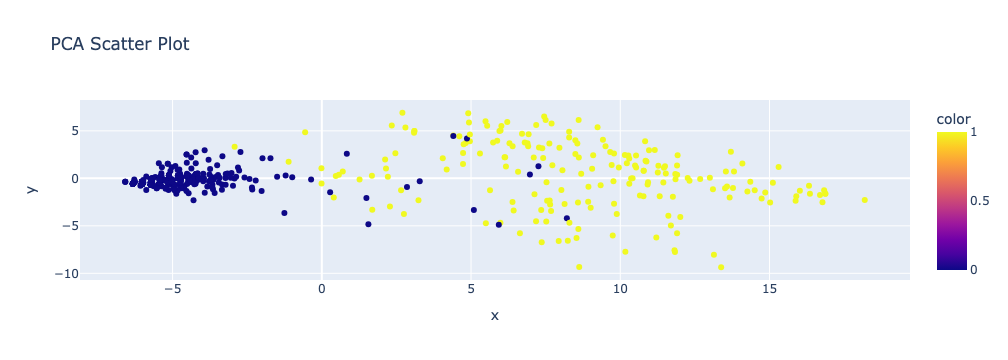

In [110]:
pca_fig

### PREDICTIVE VISUALIZATION FUNCTIONS

In [81]:
def get_confusion_matrix_fig(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(
        cm,
        text_auto=True,
        labels={"x": "Predicted", "y": "Actual", "color": "Count"},
        title="Confusion Matrix"
    )
    return fig


def get_roc_curve_fig(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines",
                             name=f"AUC = {roc_auc:.3f}"))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines",
                             line=dict(dash="dash"), name="Baseline"))
    fig.update_layout(
        title="ROC Curve",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate"
    )
    return fig


def get_feature_importance_fig(model, feature_names):
    importances = model.feature_importances_
    df = pd.DataFrame({"Feature": feature_names,
                       "Importance": importances}).sort_values(
                           "Importance", ascending=False)

    fig = px.bar(
        df, x="Importance", y="Feature",
        orientation="h",
        title="Feature Importances"
    )
    fig.update_layout(yaxis={"categoryorder": "total ascending"})
    return fig


def classification_report_to_df(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).T.reset_index()
    df.rename(columns={"index": "Class"}, inplace=True)
    return df


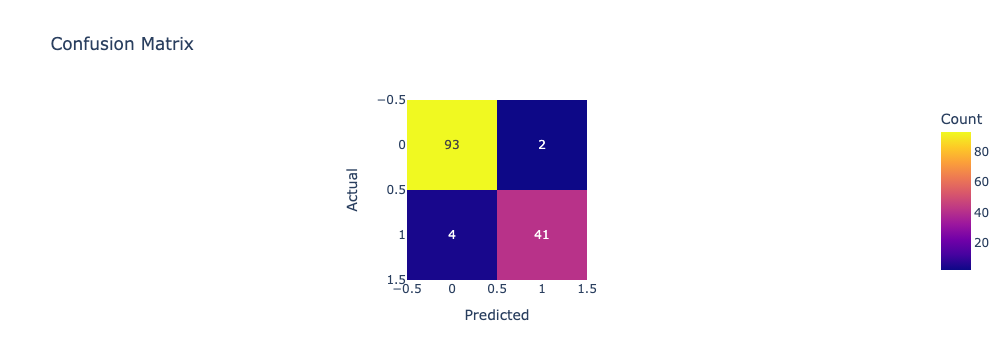

In [83]:
get_confusion_matrix_fig(y_test,y_pred)

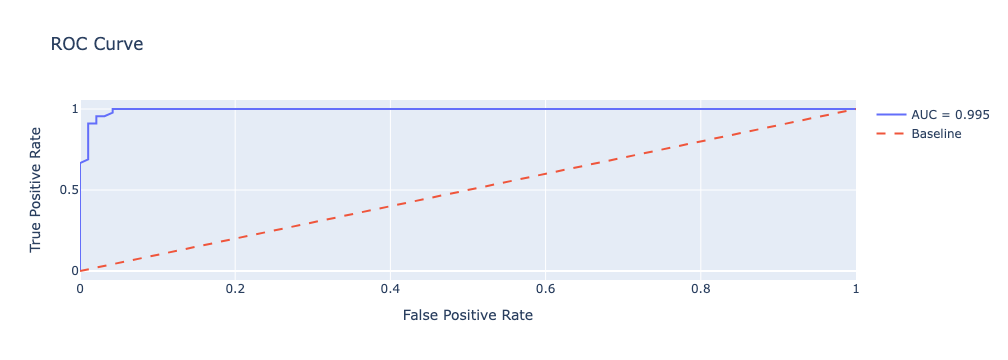

In [85]:
get_roc_curve_fig(y_test, y_proba)

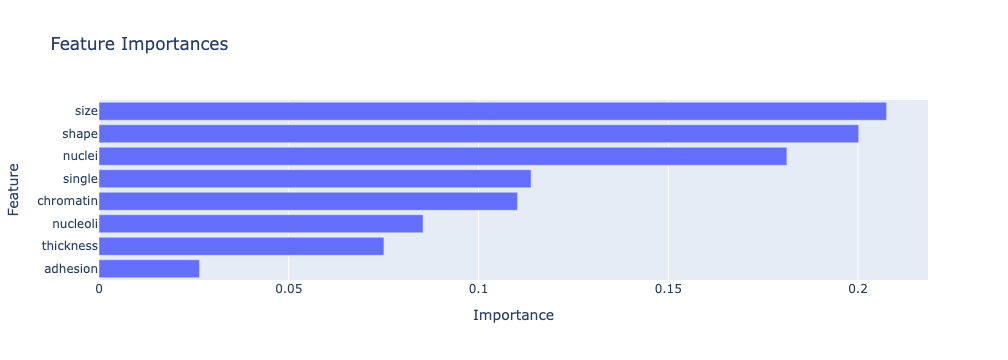

In [87]:
get_feature_importance_fig(rf, feature_list)

In [89]:
classification_report_to_df(y_test, y_pred)

,Class,precision,recall,f1-score,support
0,0,0.958763,0.978947,0.968750,95.000000
1,1,0.953488,0.911111,0.931818,45.000000
2,accuracy,0.957143,0.957143,0.957143,0.957143
3,macro avg,0.956126,0.945029,0.950284,140.000000
4,weighted avg,0.957068,0.957143,0.956879,140.000000


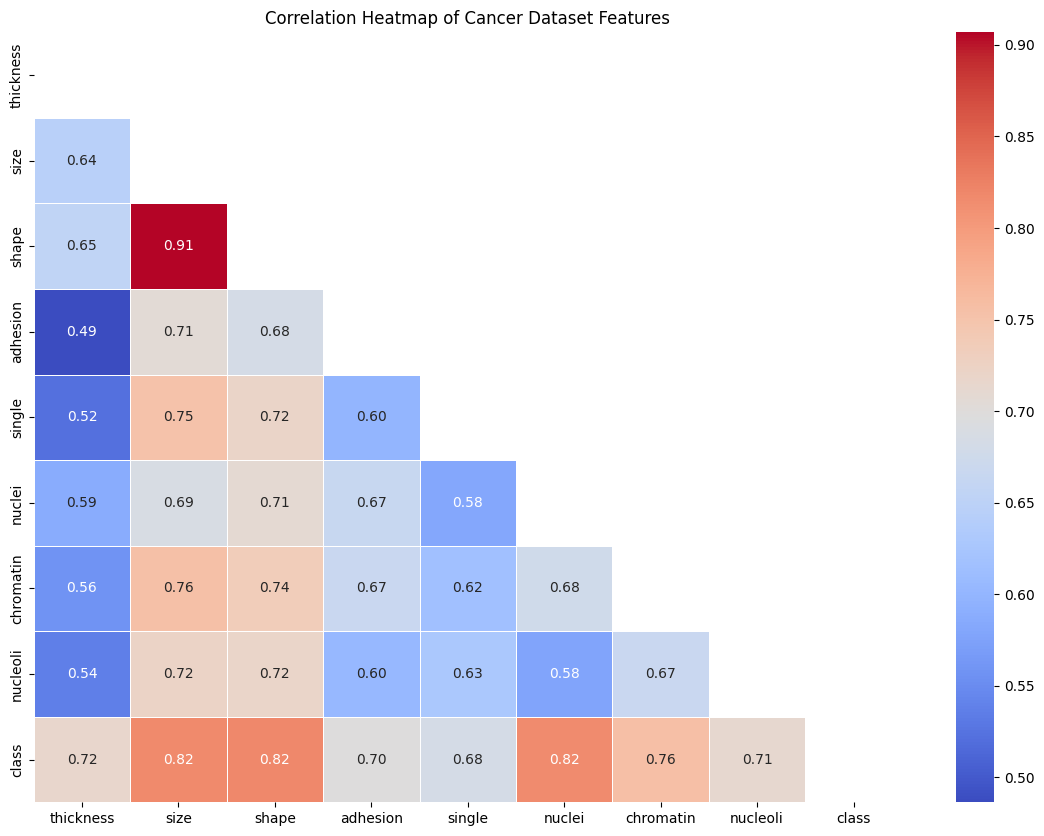

In [113]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df.corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(corr, mask=mask, annot=True, 
            cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlation Heatmap of Cancer Dataset Features')
plt.show()


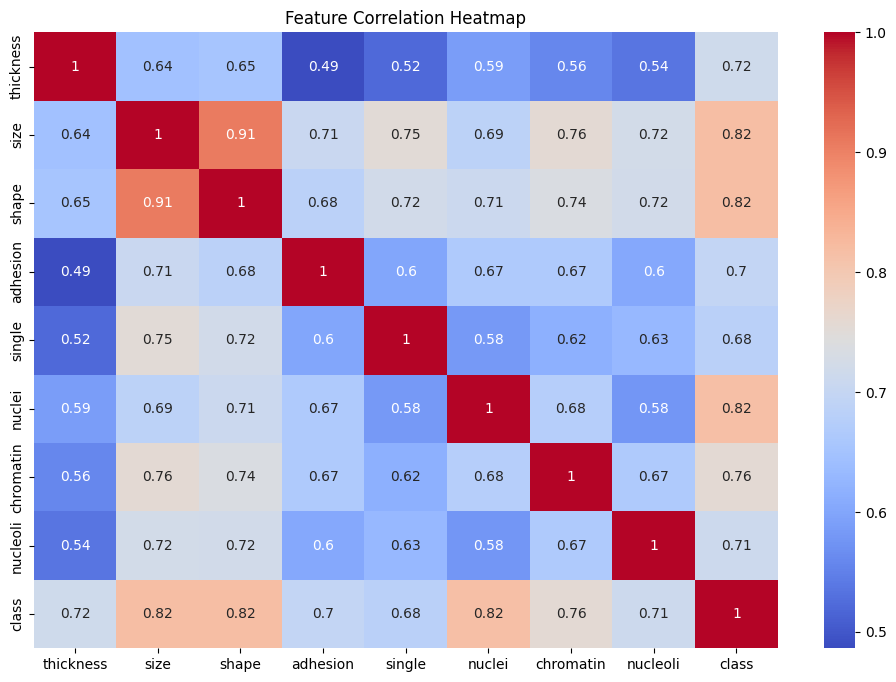

In [115]:

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


### DASH APP SETUP

In [107]:
# ==========================================================
# ③ DASH APP SETUP
# ==========================================================

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

tabs = dcc.Tabs([

    # ---------------------- TAB 1: EDA ----------------------
    dcc.Tab(label="Exploratory Data Analysis", children=[
        dbc.Container([
            html.H3("EDA Visualizations", className="my-3"),

            dbc.Row([
                dbc.Col(dcc.Graph(figure=eda_fig_1), md=6),
                dbc.Col(dcc.Graph(figure=eda_fig_2), md=6)
            ])
        ], fluid=True)
    ]),

    # ---------------------- TAB 2: PCA ----------------------
    dcc.Tab(label="PCA Insights", children=[
        dbc.Container([
            html.H3("PCA Visualization", className="my-3"),
            dcc.Graph(figure=pca_fig)
        ], fluid=True)
    ]),

    # --------------- TAB 3: Predictive Modeling -------------
    dcc.Tab(label="Predictive Modeling", children=[
        dbc.Container([

            html.H3("Predictive Model Performance", className="my-3"),

            dbc.Row([
                dbc.Col(
                    dcc.Graph(
                        figure=get_confusion_matrix_fig(y_test, y_pred),
                        id="cm"
                    ),
                    md=6
                ),
                dbc.Col(
                    dcc.Graph(
                        figure=get_roc_curve_fig(y_test, y_proba),
                        id="roc"
                    ),
                    md=6
                ),
            ], className="my-4"),

            dbc.Row([
                dbc.Col(
                    dcc.Graph(
                        figure=get_feature_importance_fig(rf, feature_list),
                        id="fi"
                    ),
                    md=6
                ),

                dbc.Col(
                    dbc.Card(
                        dbc.CardBody([
                            html.H4("Classification Report"),
                            dbc.Table.from_dataframe(
                                classification_report_to_df(y_test, y_pred),
                                striped=True,
                                bordered=True,
                                hover=True
                            )
                        ])
                    ),
                    md=6
                )
            ])

        ], fluid=True)
    ])

])

app.layout = dbc.Container([
    html.H1("Cancer Dataset Analytics Dashboard", className="text-center my-4"),
    tabs
], fluid=True)

if __name__ == "__main__":
    app.run(debug=True, port=8060)
